Nombre:Ester Solamyt Atao Surichaqui

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


El propósito de este código es descargar un archivo ZIP desde Google Drive, extraer su contenido y listar los archivos que se han extraído.

In [ ]:
import gdown
import zipfile
import os

# ID del archivo de Google Drive
file_id = '1UGGuSSHsqPANNevuqwPA598mJ6nPZa1i'

# Formar el enlace de descarga directa
download_url = f'https://drive.google.com/uc?id={file_id}'

# Descargar el archivo usando gdown
gdown.download(download_url, 'archivo.zip', quiet=False)

# Ruta al archivo ZIP descargado
zip_file_path = 'archivo.zip'

# Ruta donde deseas extraer los archivos
extract_path = '/content/extracted_files'

# Asegúrate de que la carpeta de extracción exista
os.makedirs(extract_path, exist_ok=True)

# Extraer el contenido del archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Listar los archivos extraídos
print(os.listdir(extract_path))

Downloading...
From (original): https://drive.google.com/uc?id=1UGGuSSHsqPANNevuqwPA598mJ6nPZa1i
From (redirected): https://drive.google.com/uc?id=1UGGuSSHsqPANNevuqwPA598mJ6nPZa1i&confirm=t&uuid=ec66853e-852a-4ab1-9720-4c7a790cda67
To: /content/archivo.zip
100%|██████████| 128M/128M [00:01<00:00, 72.3MB/s]


['dogvscat_small']


Este código está preparado para realizar procesamiento de imágenes, clasificación con una máquina de soporte vectorial (SVM), y visualización de datos utilizando herramientas como TSNE y Plotly.


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go

Define las rutas de los directorios de entrenamiento y prueba.

In [ ]:
train_dir = '/content/extracted_files/dogvscat_small/train'
test_dir = '/content/extracted_files/dogvscat_small/test'

Recorre el directorio de entrenamiento y distingue entre archivos y subdirectorios.

In [ ]:
for f in os.listdir(train_dir):
    full_path = os.path.join(train_dir, f)
    if os.path.isfile(full_path):
        print(f"File: {f}")
    else:
        print(f"Directory: {f}")

Directory: cats
Directory: dogs


Antes de listar los archivos y subdirectorios, agregue una verificación adicional para asegurarse de que el directorio de entrenamiento existe y no está vacío.



In [ ]:
import os

train_dir = '/content/extracted_files/dogvscat_small/train'

# Verificar si el directorio existe
if os.path.exists(train_dir):
    print("Directorio encontrado:", train_dir)
    files = os.listdir(train_dir)

    if files:
        print("Archivos en el directorio:")
        for file in files:
            file_path = os.path.join(train_dir, file)
            if os.path.isfile(file_path):
                print(f"  Archivo: {file}")
            else:
                print(f"  Subdirectorio: {file}")
    else:
        print("El directorio está vacío.")
else:
    print("El directorio no existe.")

Directorio encontrado: /content/extracted_files/dogvscat_small/train
Archivos en el directorio:
  Subdirectorio: cats
  Subdirectorio: dogs


## Funciones para cargar y procesar las imágenes

Es posible cargar imágenes desde un directorio de varias maneras. La función load_images carga una cantidad específica de imágenes y sus etiquetas, normalizando los valores de píxeles para que se encuentren en el rango [0, 1]. Visualize_images muestra las imágenes junto con sus etiquetas, lo cual es útil para verificar que se han cargado y etiquetado correctamente.


In [ ]:
import os
import random
import numpy as np
from PIL import Image

def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):

    images = []
    labels = []

    try:
        filenames = os.listdir(folder)
        if label_filter:
            filenames = [fname for fname in filenames if label_filter in fname]

        if sample_count > len(filenames):
            sample_count = len(filenames)  # Adjust if sample_count is more than available files

        random.shuffle(filenames)

        for img_name in filenames[:sample_count]:
            img_path = os.path.join(folder, img_name)
            try:
                with Image.open(img_path) as img_pil:
                    img_pil = img_pil.resize(img_size)
                    img_np = np.array(img_pil) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_np)
                    labels.append(0 if 'cat' in img_name else 1)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

    except Exception as e:
        print(f"Error accessing folder {folder}: {e}")

    return np.array(images), np.array(labels)

In [ ]:
import matplotlib.pyplot as pltBLOQUE 8

def visualize_images(images, labels, sample_count=20):

    # Limit the sample count to a maximum of 20 images
    max_display = min(sample_count, len(images), 20)

    # Calculate the number of rows and columns for subplots
    rows = (max_display + 4) // 5  # Ensure enough rows for all images
    cols = 5

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()

    for i in range(max_display):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')

    # Turn off any remaining axes
    for j in range(max_display, rows * cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Cargando imágenes desde el subdirectorio: cats
Cargando imágenes desde el subdirectorio: dogs
Images shape: (40, 64, 64, 3)
Labels shape: (40,)


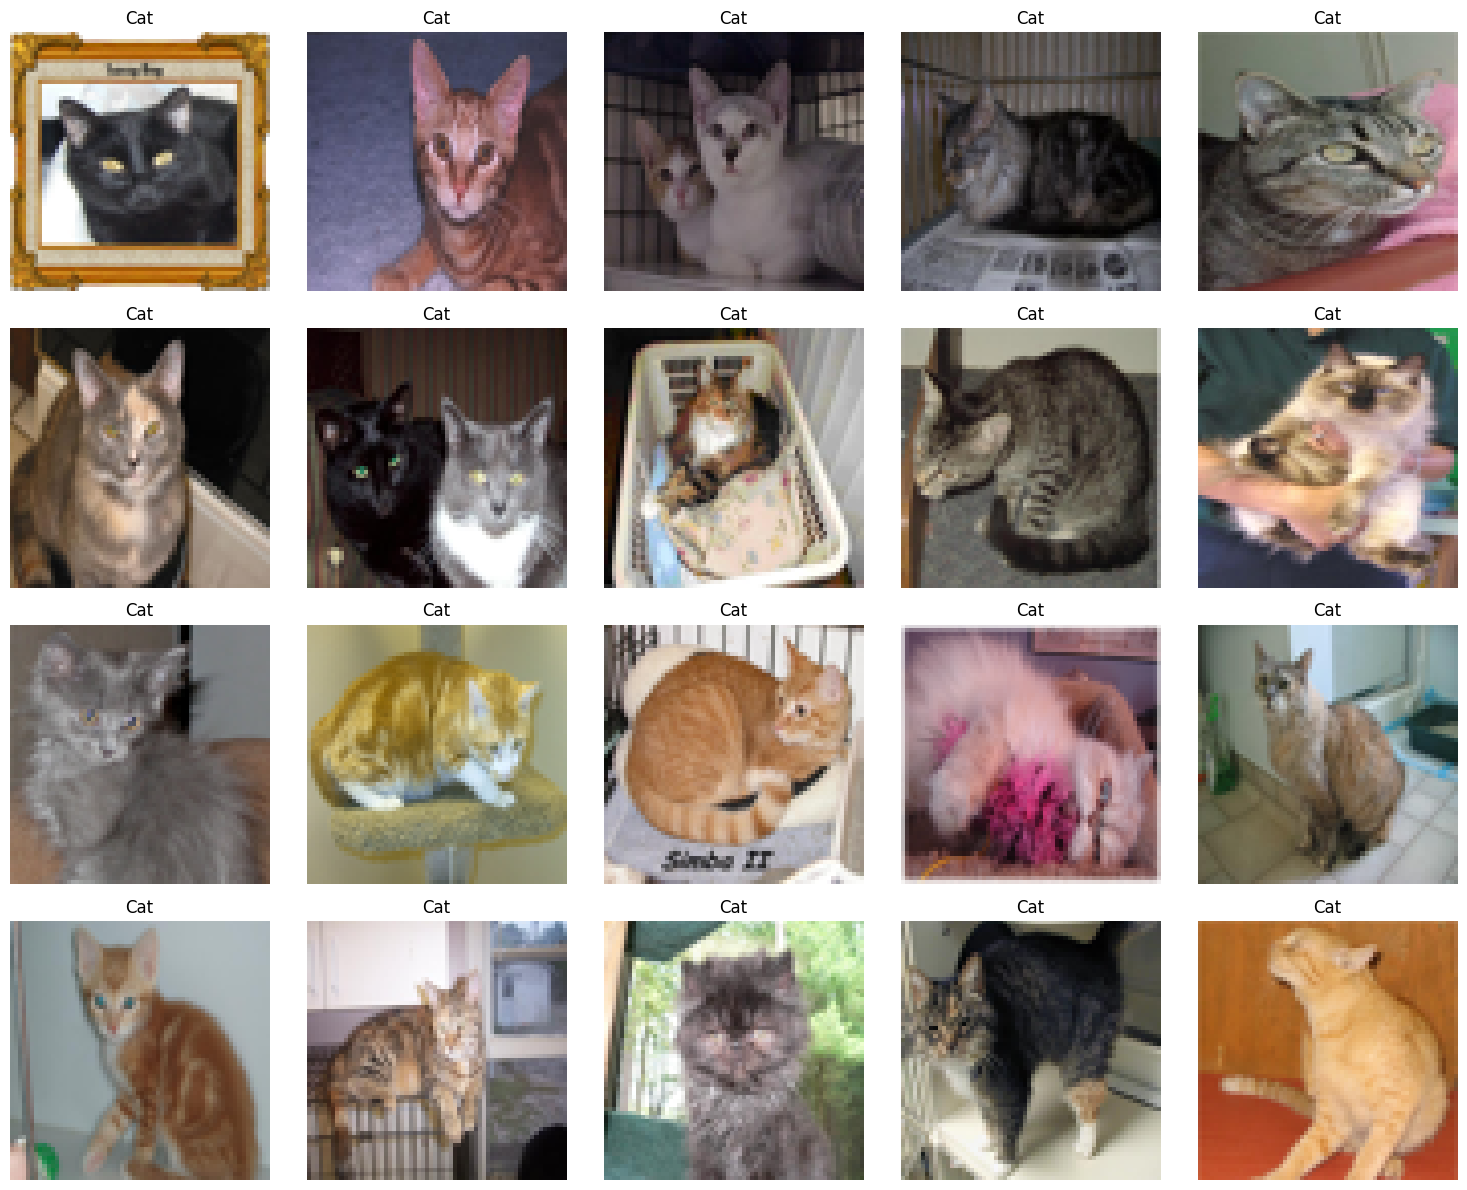

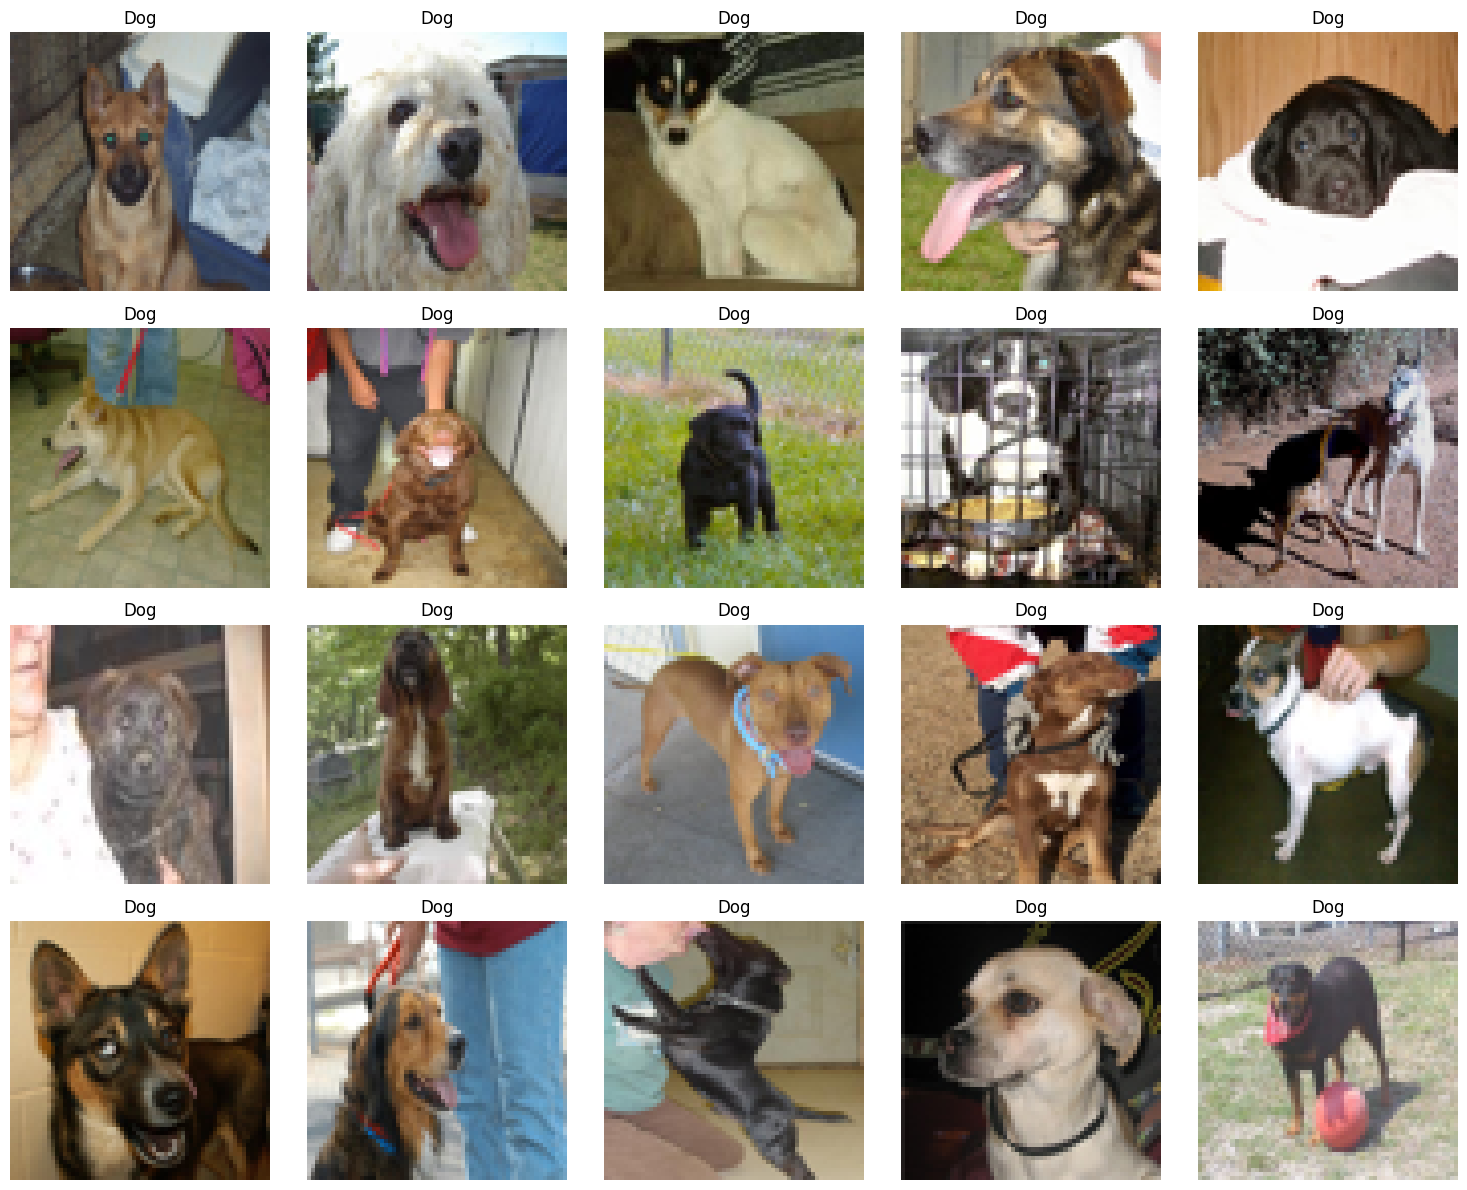

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

def load_images_from_subdirectories(folder, img_size=(64, 64), sample_count=20):

    images = []
    labels = []

    # Recorrer subdirectorios
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)

        if os.path.isdir(subdir_path):
            print(f"Cargando imágenes desde el subdirectorio: {subdir}")

            # Listar archivos en el subdirectorio
            filenames = os.listdir(subdir_path)
            random.shuffle(filenames)  # Barajar archivos

            # Limitar el número de muestras al menor de sample_count o el número de archivos disponibles
            count = min(sample_count, len(filenames))

            for img in filenames[:count]:
                img_path = os.path.join(subdir_path, img)
                try:
                    img_pil = Image.open(img_path).convert('RGB')
                    img_pil = img_pil.resize(img_size)
                    img_np = np.array(img_pil) / 255.0  # Normalizar valores de píxeles
                    images.append(img_np)
                    labels.append(0 if subdir == 'cats' else 1)
                except Exception as e:
                    print(f"Error cargando la imagen {img} en {subdir}: {e}")

    return np.array(images), np.array(labels)

def visualize_images_by_class(images, labels):

    # Filtrar imágenes por clase
    unique_labels = np.unique(labels)
    classes = {0: 'Cat', 1: 'Dog'}

    for label in unique_labels:
        class_images = images[labels == label]

        if len(class_images) > 0:
            fig, axes = plt.subplots(4, 5, figsize=(15, 12))
            axes = axes.flatten()

            for i in range(min(20, len(class_images))):
                axes[i].imshow(class_images[i])
                axes[i].set_title(classes[label])
                axes[i].axis('off')

            for j in range(len(class_images), 20):  # Apagar ejes adicionales si hay menos de 20 imágenes
                axes[j].axis('off')

            plt.tight_layout()
            plt.show()

# Especificar el directorio de entrenamiento (cambiar 'train_dir' por la ruta correcta)
train_dir ='/content/extracted_files/dogvscat_small/train'

# Cargar imágenes
images, labels = load_images_from_subdirectories(train_dir, sample_count=20)
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Visualizar imágenes por clase
visualize_images_by_class(images, labels)

## Carga y procesamiento de los datos para el procesamiento

Este bloque se enfoca en cargar imágenes de subdirectorios particulares, como "gatos" y "perros". Cada subdirectorio es visitado por la función load_images_from_subdirectories, que carga imágenes y asigna etiquetas según el nombre del subdirectorio. Esto hace posible organizar los datos para entrenar un modelo de clasificación.

In [ ]:
import numpy as np
import os
from PIL import Image
import random

def load_images(folder, img_size=(64, 64), sample_count=20):

    images = []
    labels = []

    # Recorrer subdirectorios
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)

        if os.path.isdir(subdir_path):  # Verificar si es un directorio
            print(f"Cargando imágenes desde el subdirectorio: {subdir}")

            # Listar archivos de imagen en el subdirectorio
            filenames = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            random.shuffle(filenames)  # Barajar archivos

            # Limitar el número de muestras al menor de sample_count o el número de archivos disponibles
            count = min(sample_count, len(filenames))

            for img in filenames[:count]:
                img_path = os.path.join(subdir_path, img)
                try:
                    with Image.open(img_path).convert('RGB') as img_pil:
                        img_pil = img_pil.resize(img_size)
                        img_np = np.array(img_pil) / 255.0  # Normalizar valores de píxeles
                        images.append(img_np)
                        labels.append(0 if 'cat' in subdir.lower() else 1)
                except Exception as e:
                    print(f"Error cargando la imagen {img} en {subdir}: {e}")

    return np.array(images), np.array(labels)

# Especificar el directorio de entrenamiento
train_dir = '/content/extracted_files/dogvscat_small/train'

# Cargar y normalizar las imágenes directamente
images, labels = load_images(train_dir, sample_count=10000)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Cargando imágenes desde el subdirectorio: cats
Cargando imágenes desde el subdirectorio: dogs
Images shape: (2000, 64, 64, 3)
Labels shape: (2000,)


## Definición del modelo

La función build_cnn_model se utiliza para definir la estructura del modelo de red neuronal convolucional (CNN). Para la clasificación final, se especifican varias capas convolucionales y de agrupamiento, así como capas densas. Este modelo tiene como objetivo aprender a diferenciar las imágenes de gatos y perros.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_cnn_model(input_shape=(150, 150, 3)):

    model = models.Sequential([
        # Primera capa de convolución y agrupación
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Segunda capa de convolución y agrupación
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Tercera capa de convolución y agrupación
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Cuarta capa de convolución y agrupación
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Aplanar las salidas para conectarlas a las capas completamente conectadas
        layers.Flatten(),

        # Calcular el tamaño de la primera capa densa
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Añadir dropout para evitar sobreajuste

        # Capa densa adicional según el diseño original
        layers.Dense(256, activation='relu'),

        # Capa de salida con activación sigmoide para clasificación binaria
        layers.Dense(1, activation='sigmoid')
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Crear el modelo CNN
model = build_cnn_model(input_shape=(150, 150, 3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Generador de datos

Se crea un generador de datos para alimentar al modelo durante el entrenamiento. Para aplicar modificaciones a las imágenes, como la normalización de píxeles, se utiliza ImageDataGenerator. Esto es fundamental para el entrenamiento porque permite manejar una gran cantidad de datos sin cargar todo en la memoria.

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_image_generators(base_dir, target_size=(150, 150), batch_size=20):
    # Directorios para los datos
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')

    # Crear instancias de ImageDataGenerator
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Generador de datos para entrenamiento
    train_generator = train_datagen.flow_from_directory(
        train_dir,                  # Directorio de imágenes de entrenamiento
        target_size=target_size,    # Redimensionar las imágenes
        batch_size=batch_size,      # Número de imágenes por lote
        class_mode='binary'         # Clasificación binaria: perro o gato
    )

    # Generador de datos para validación
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,             # Directorio de imágenes de validación
        target_size=target_size,    # Redimensionar las imágenes
        batch_size=batch_size,      # Número de imágenes por lote
        class_mode='binary'         # Clasificación binaria: perro o gato
    )

    return train_generator, validation_generator

# Configurar los directorios y parámetros
base_dir = '/content/extracted_files/dogvscat_small'
target_size = (150, 150)
batch_size = 20

# Crear generadores de imágenes
train_generator, validation_generator = create_image_generators(
    base_dir=base_dir,
    target_size=target_size,
    batch_size=batch_size
)

# Los generadores están listos para usarse en el entrenamiento del modelo.

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Importar las librerías necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios para los datos
base_dir = '/content/extracted_files/dogvscat_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Crear instancias de ImageDataGenerator para entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Usar un subconjunto para validación
validation_datagen = ImageDataGenerator(rescale=1./255)

# Generador de datos para entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='training'  # Usar solo la parte de entrenamiento
)

# Generador de datos para validación
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Extraer datos y etiquetas para entrenamiento y validación
X_train, y_train = next(train_generator)
X_val, y_val = next(validation_generator)


Found 1600 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Definir la función de entrenamiento del modelo
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=5, verbose=1):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=verbose
    )
    return history

# Configurar los parámetros de entrenamiento
epochs = 20
batch_size = 5

# Entrenar el modelo
history = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.4933 - loss: 0.7615 - val_accuracy: 0.4000 - val_loss: 0.7060
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5267 - loss: 0.7267 - val_accuracy: 0.4000 - val_loss: 0.7257
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5800 - loss: 0.7044 - val_accuracy: 0.4000 - val_loss: 0.6980
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3933 - loss: 0.6966 - val_accuracy: 0.5500 - val_loss: 0.6911
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6000 - loss: 0.6886 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6400 - loss: 0.6867 - val_accuracy: 0.4000 - val_loss: 0.6998
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6933 - loss: 0.6444 - val_accuracy: 0.7000 - val_loss: 0.6594
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6136 - val_accuracy: 0.4500 - val_loss: 0.768

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.5117
Validation Loss: 1.5116769075393677
Validation Accuracy: 0.5


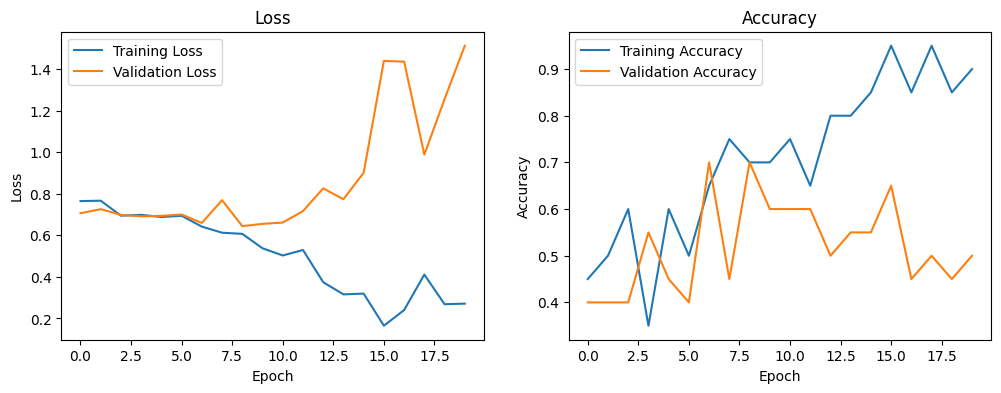

In [ ]:
import matplotlib.pyplot as plt

def evaluate_model(model, X_val, y_val):

    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Validation Loss: {loss}')
    print(f'Validation Accuracy: {accuracy}')
    return loss, accuracy

def plot_training_history(history):

    plt.figure(figsize=(12, 4))

    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Evaluar el modelo
loss, accuracy = evaluate_model(model, X_val, y_val)

# Graficar las métricas de entrenamiento
plot_training_history(history)

## Aumento de datos

Para mejorar la generalización del modelo, este bloque implementa métodos de aumento de datos. Las transformaciones de rotación y desplazamiento se aplican a las imágenes durante el entrenamiento. Esto puede mejorar el rendimiento del modelo al facilitar la creación de variaciones en los datos de entrada.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_model(input_shape=(150, 150, 3)):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', input_shape=input_shape),
        layers.MaxPooling2D((2, 2), name='maxpool_1'),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'),
        layers.MaxPooling2D((2, 2), name='maxpool_2'),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'),
        layers.MaxPooling2D((2, 2), name='maxpool_3'),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'),
        layers.MaxPooling2D((2, 2), name='maxpool_4'),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', name='dense_1'),
        layers.Dense(256, activation='relu', name='dense_2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_generators(train_dir, validation_dir, target_size=(150, 150), batch_size=32):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_generator, validation_generator

def train_model(model, train_generator, validation_generator, epochs=60):

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        verbose=1
    )
    return history

# Configuración de directorios y parámetros
base_dir = '/content/extracted_files/dogvscat_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Construir el modelo
model_aug = build_model(input_shape=(150, 150, 3))

# Preparar los generadores de datos
train_generator, validation_generator = prepare_data_generators(train_dir, validation_dir, target_size=(150, 150), batch_size=32)

# Entrenar el modelo
history_aug = train_model(model_aug, train_generator, validation_generator, epochs=60)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.4978 - loss: 0.6997 - val_accuracy: 0.5050 - val_loss: 0.7398
Epoch 2/60
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6250 - loss: 0.6090

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6250 - loss: 0.6090 - val_accuracy: 0.3750 - val_loss: 0.8276
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.5252 - loss: 0.6919 - val_accuracy: 0.5373 - val_loss: 0.6905
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 0.6915 - val_accuracy: 0.7500 - val_loss: 0.6893
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 261ms/step - accuracy: 0.5131 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.5312 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.5092 - loss: 0.6930 - val_accuracy: 0.5504 - val_loss: 0.6924
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.5625 - loss: 0.6926 - val_accuracy: 0.2500 - val_loss: 0.6945
Epoch 9/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - accuracy: 0.5306 - loss: 0.6910 - val_accuracy: 0.5212 - val

## Guardar y actualizar el modelo y el historial

Se definen funciones para guardar el modelo entrenado y el historial de entrenamiento en archivos. save_model guarda el modelo en formato HDF5, mientras que save_training_history guarda el historial en un archivo binario. Esto permite reutilizar el modelo y analizar el rendimiento más tarde.

In [ ]:
import pickle
import tensorflow as tf

def save_model(model, filename):

    model.save(filename)
    print(f"Modelo guardado en {filename}")

def save_training_history(history, filename):

    with open(filename, 'wb') as file:
        pickle.dump(history.history, file)
    print(f"Historial de entrenamiento guardado en {filename}")

# Guardar el modelo
save_model(model_aug, 'model_aug.h5')

# Guardar el historial del entrenamiento
save_training_history(history_aug, 'history_aug.bin')

Modelo guardado en model_aug.h5
Historial de entrenamiento guardado en history_aug.bin


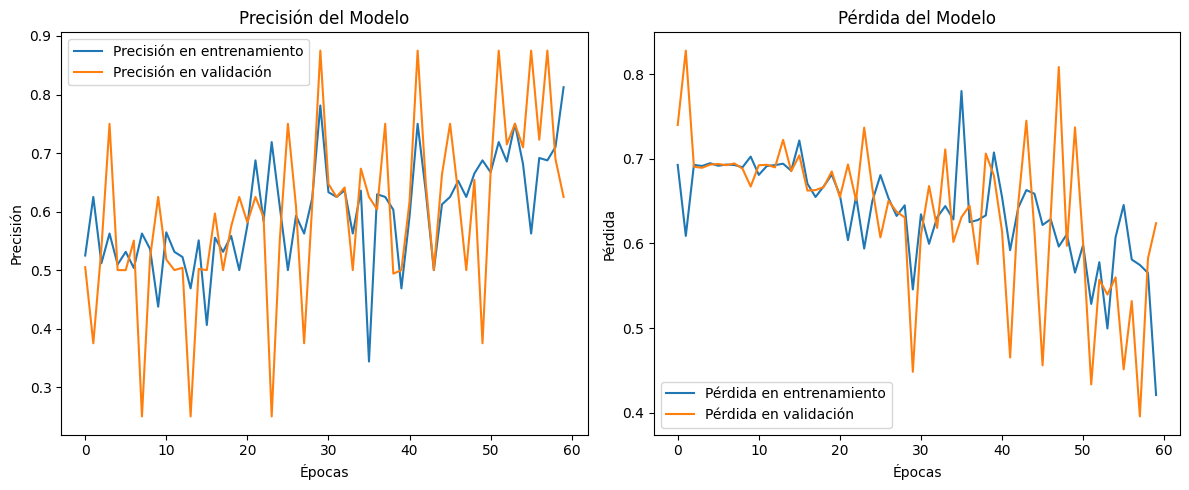

In [ ]:
import matplotlib.pyplot as plt
import pickle

def load_training_history(filename):

    with open(filename, 'rb') as file:
        return pickle.load(file)

def plot_training_performance(history, steps=50):

    plt.figure(figsize=(12, 5))

    # Graficar la precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.get('accuracy', []), label='Precisión en entrenamiento')
    plt.plot(history.get('val_accuracy', []), label='Precisión en validación')
    plt.title('Precisión del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Graficar la pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.get('loss', []), label='Pérdida en entrenamiento')
    plt.plot(history.get('val_loss', []), label='Pérdida en validación')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Cargar el historial del entrenamiento
history_aug = load_training_history('history_aug.bin')

# Graficar el rendimiento del modelo
plot_training_performance(history_aug)

# Modelo VGG

La función build_cnn_model se utiliza para definir la estructura del modelo de red neuronal convolucional (CNN). Para la clasificación final, se especifican varias capas convolucionales y de agrupamiento, así como capas densas. Este modelo tiene como objetivo aprender a diferenciar las imágenes de gatos y perros.

In [ ]:
from tensorflow.keras.applications import VGG16

def load_vgg16_model(input_shape=(150, 150, 3)):

    model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    return model

def display_model_summary(model):
    model.summary()

# Cargar el modelo VGG16
vgg16_model = load_vgg16_model()

# Visualización

Se especifican funciones para visualizar las activaciones de las capas convolucionales y los filtros de la primera capa del modelo VGG16. Esto ayuda a entender cómo el modelo procesa las imágenes y qué características aprende.

Tensor shape: (1, 150, 150, 3)


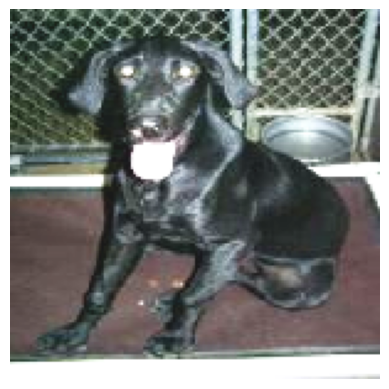

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(150, 150)):
    # Cargar la imagen con el tamaño objetivo
    img = image.load_img(img_path, target_size=target_size)

    # Convertir la imagen a un array de NumPy
    img_tensor = image.img_to_array(img)

    # Añadir una dimensión para el batch
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # Normalizar los valores de los píxeles
    img_tensor /= 255.0

    return img_tensor

def visualize_image(img_tensor):

    # Mostrar la primera (y única) imagen del batch
    plt.imshow(img_tensor[0])

    # No mostrar los ejes
    plt.axis('off')

    # Mostrar la imagen
    plt.show()

# Ruta de la imagen
img_path = '/content/extracted_files/dogvscat_small/train/dogs/50.jpg'

# Cargar y preprocesar la imagen
img_tensor = load_and_preprocess_image(img_path)

# Imprimir la forma del tensor
print(f'Tensor shape: {img_tensor.shape}')

# Visualizar la imagen
visualize_image(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


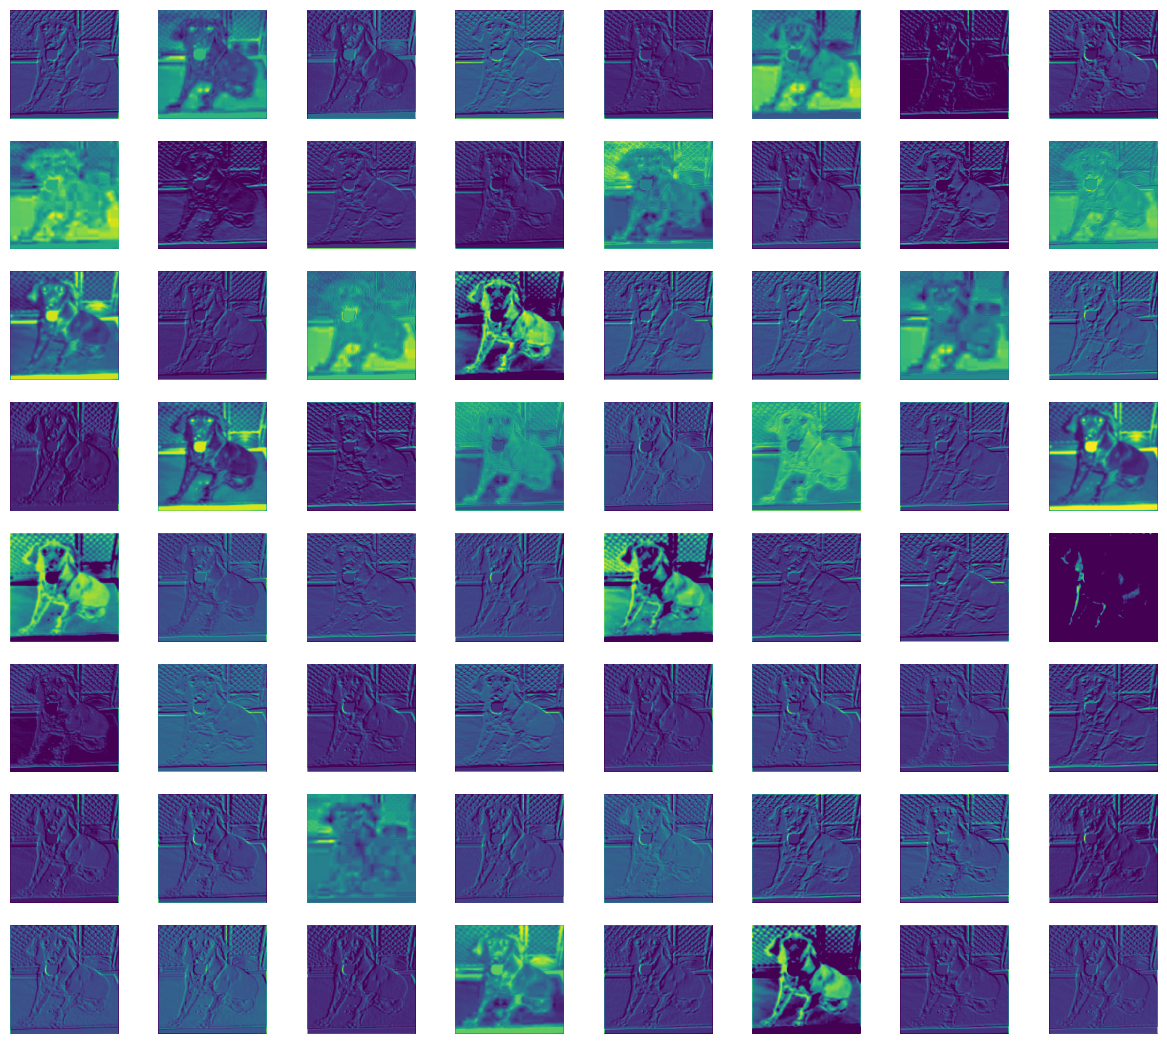

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def load_vgg16_model(input_shape=(150, 150, 3)):

    return VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

def preprocess_image(img_path, target_size=(150, 150)):

    img = image.load_img(img_path, target_size=target_size)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0
    return img_tensor

def get_layer_activations(model, img_tensor):

    # Definir el modelo para extraer las activaciones de las capas convolucionales
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    # Obtener las activaciones intermedias
    activations = activation_model.predict(img_tensor)
    return activations

def visualize_activations(activations):
    first_layer_activation = activations[0]
    num_filters = first_layer_activation.shape[-1]

    plt.figure(figsize=(15, 15))
    for i in range(num_filters):
        plt.subplot(num_filters // 8 + 1, 8, i + 1)
        plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

# Ruta de la imagen
img_path = '/content/extracted_files/dogvscat_small/train/dogs/50.jpg'

# Cargar el modelo VGG16
vgg16_model = load_vgg16_model()

# Preprocesar la imagen
img_tensor = preprocess_image(img_path)

# Obtener activaciones de las capas convolucionales
activations = get_layer_activations(vgg16_model, img_tensor)

# Visualizar las activaciones de la primera capa convolucional
visualize_activations(activations)

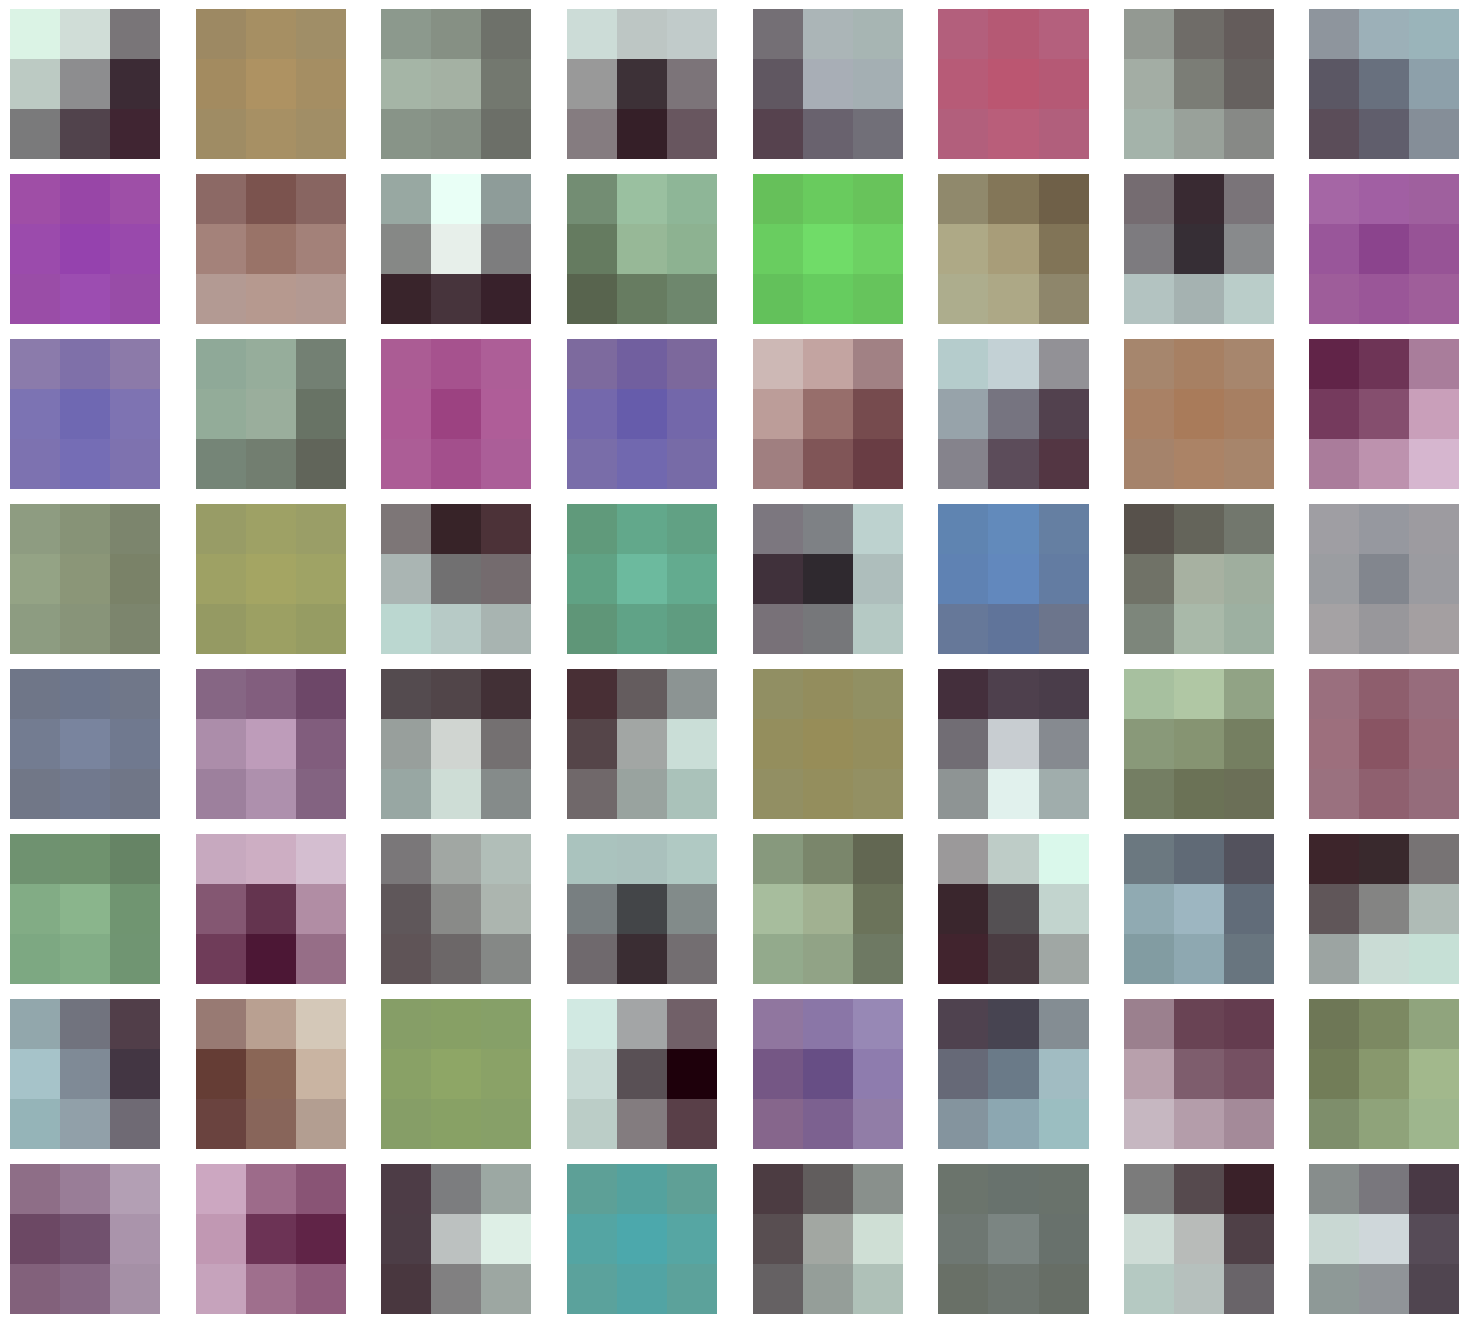

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16

def load_vgg16_model(input_shape=(150, 150, 3)):

    return VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

def get_first_conv_layer_filters(model):
    # Seleccionar la primera capa convolucional
    first_conv_layer = model.layers[1]  # Capa Conv2D de VGG16

    # Obtener los filtros y sesgos de la capa
    filters, _ = first_conv_layer.get_weights()
    return filters

def normalize_filters(filters):

    return (filters - np.min(filters)) / (np.max(filters) - np.min(filters))

def visualize_filters(filters):
    num_filters = filters.shape[3]
    plt.figure(figsize=(15, 15))
    for i in range(num_filters):
        plt.subplot(num_filters // 8 + 1, 8, i + 1)
        plt.imshow(filters[:, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Cargar el modelo VGG16
vgg16_model = load_vgg16_model()

# Obtener y normalizar los filtros de la primera capa convolucional
filters = get_first_conv_layer_filters(vgg16_model)
normalized_filters = normalize_filters(filters)

# Visualizar los filtros
visualize_filters(normalized_filters)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1: Labrador_retriever (0.68)
2: flat-coated_retriever (0.05)
3: German_short-haired_pointer (0.05)


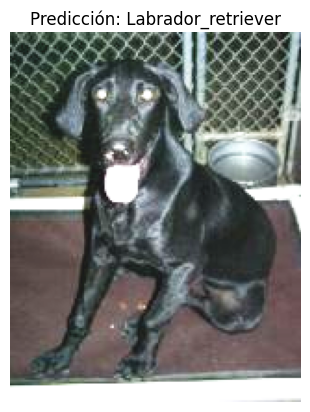

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

def load_vgg16_model(include_top=True):

    return VGG16(weights='imagenet', include_top=include_top)

def preprocess_image(img_path, target_size=(224, 224)):

    img = image.load_img(img_path, target_size=target_size)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = preprocess_input(img_tensor)
    return img_tensor

def predict_image_class(model, img_tensor):

    predictions = model.predict(img_tensor)
    return decode_predictions(predictions, top=3)[0]

def display_predictions(decoded_predictions):

    for i, (class_id, class_name, score) in enumerate(decoded_predictions):
        print(f"{i + 1}: {class_name} ({score:.2f})")

def display_image_with_prediction(img_path, decoded_predictions):

    img = image.load_img(img_path)  # Recargar imagen para mostrarla
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción: {decoded_predictions[0][1]}")
    plt.show()

# Ruta de la imagen
img_path = '/content/extracted_files/dogvscat_small/train/dogs/50.jpg'  # Actualiza con la ruta a tu imagen

# Cargar el modelo VGG16 con la capa superior
vgg_model = load_vgg16_model(include_top=True)

# Preprocesar la imagen
img_tensor = preprocess_image(img_path)

# Realizar la predicción
decoded_predictions = predict_image_class(vgg_model, img_tensor)

# Mostrar las predicciones
display_predictions(decoded_predictions)

# Mostrar la imagen con la predicción
display_image_with_prediction(img_path, decoded_predictions)